# Simple fits

Here we are fitting a line from scratch.
In the next notebook, we will do fancier fits with neural networks, but let's start with a basic problem and complicate it as we go along.


In [1]:
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


We start by generating some fake dataset, which is simple enough that we can visualize the results easily. For this reason, the dataset will contain only two  variables.

The simulated example data will be $f(x) = 3 x + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu=0, \sigma=0.5)$.


In [3]:
def generate_data(N: int) -> np.ndarray:
    x = 2*np.random.randn(N, 1)
    epsilon = 0.5*np.random.randn(N, 1)
    z = 3*x + epsilon
    return np.concatenate((x, z), axis=1).astype(np.float32)

data = generate_data(N=1000)

In [8]:
data = np.concatenate([data,
                       np.array([[10.0, -4.0],
                                 [5.0, -5.0]])
                      ], axis=0)

We can fit this line from scratch, assuming $y = f(x) = \beta x + \alpha + \epsilon$, where $\epsilon$ is a zero-mean Gaussian noise.

We can do this in two ways. In both cases, we start assuming the knowledge of $f(x)$ and use the Bayes Theorem:

$ p(\alpha, \beta|\mathcal{D}) \, \propto p(\mathcal{D}|\alpha, \beta) \, p(\alpha) \, p(\beta)$

We assume $p(\alpha)$ and $p(\beta)$ are constants, so we just need to maximize the likelihood $p(\mathcal{D}|\alpha, \beta)$.
That likelihood is a Gaussian distribution, because we assumed $y$ is exactly equals to a line plus some Gaussian noise coming from $\epsilon$.

$p(\alpha,\beta|\mathcal{D}) \propto \prod \mathcal{N}(y_i|\text{mean}=f(x_i), \text{std. dev.}=\sigma_\epsilon)$

This leads to minimizing $L = \sum_i (y_i - \beta x_i - \alpha)^2$, as seen in the lecture (simply take $- \log p$ and to maximize $p$, one has to minimize $-\log p$).

We can try finding out $\beta$ and $\alpha$ by taking the derivative of $L$ and setting it to zero:

$\frac{d L}{d\beta} = 2 \sum_i (y_i - \beta x_i - \alpha) x_i = 0$

$\frac{d L}{d\alpha} = -2 \sum_i (y_i - \beta x_i - \alpha) = 0$

Re-arranging:

$2 \sum_i (y_i x_i - \beta x_i^2 - \alpha x_i) = 0$

$2 \sum_i (y_i - \beta x_i - \alpha) = 0$

This leads to:

$ \beta \sum_i x_i^2 = \sum_i (y_i - \alpha) x_i$

$ \alpha = 1/N \sum_i y_i - \beta x_i = \mathbb{E}[y - \beta x]$

We can then substitute $\alpha$ in $\beta$:

$ \beta \sum_i x_i^2 = \sum_i y_i x_i - 1/N \sum_i \sum_j (y_j - \beta x_j) x_i$

And expand it:

$ \beta (\sum_i x_i^2 - 1/N \sum_i \sum_j x_i x_j) = \sum_i y_i x_i - 1/N \sum_i \sum_j y_j x_i$

Taking $x_j$ from a sum that does not depend on $j$, we see that the second term is just the square of the sum over $x_i$:

$ \beta (\sum_i x_i^2 - 1/N(\sum_{i} x_i)^2 ) = \sum_i y_i x_i - 1/N \sum_i \sum_j y_j x_i$

Dividing by the number of points $N$, several sums reduce to averages, which make this much easier to interpret if we use some standard identities from statistics.
For example $1/N \sum_i x_i^2 - 1/N^2 (\sum_i x_i)^2$ is a known expression for the variance of $X$. 

$ \beta \text{var}[X] = \mathbb{E}[XY] - \mathbb{E}[X]\mathbb{E}[Y]$

And the right-hand-side is a known expression for the covariance between $X$ and $Y$:

$ \beta \text{var}[X] = \text{cov}[X,Y]$

This leads to:

$\beta = \frac{\text{cov}[X,Y]}{\text{var}[X]}$

This, together with the expression from above for $\alpha$, allows us to easily fit a line in a few lines of code:

In [9]:
cov = np.cov(data[:,0], data[:,1])[0,1]
varX = np.std(data[:,0])**2
beta = cov/varX
alpha = np.mean(data[:,1] - beta*data[:,0])

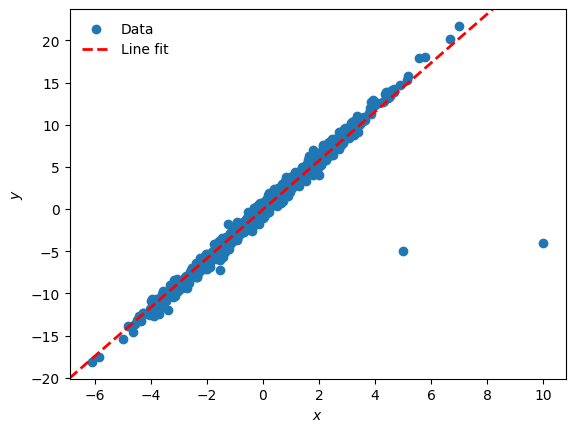

In [10]:
plt.scatter(data[:,0], data[:,1], label="Data")
plt.axline((0, alpha), slope=beta, c='r', lw=2, ls='--', label="Line fit")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(frameon=False)

Try comparing the fit result (values of $\alpha$ and $\beta$) with the simulated values in the beginning of the notebook. Are they close? Which criteria should you use to establish that they are close?

In [11]:
alpha

-0.06067522680624462

In [12]:
beta

2.89487707822029

# Why is this a terrible idea?

The previous calculation assumes that $p(\alpha)$ and $p(\beta)$, that is, the priors, are uniform. That means that any value of $\alpha$ and $\beta$ is acceptable. As we have discussed in the previous lecture, this leads to a fit that is very vulnerable to outliers. In the next notebook we will try to fix this by changing the priors to give a higher weight to values of $\alpha$ and $\beta$ close to zero, by setting $p(\alpha)$ and $p(\beta)$ to a Gaussian distribution, making an assumption on $\alpha$ and $\beta$ before looking at data. This method is called *regularization* and it starts from the assumption that, if the data has been previously *standardized*, we tend not to get wildly large values of a single parameter.

Nevertheless, the calculation above can be changed to consider a Gaussian $p(\alpha)$ and $p(\beta)$ without using the methods described in the next notebook. Feel free to try redoing the calculation at home considering that.

There are many other regularization techniques that make different assumptions on the parameters before looking at data. The choice of this method is strongly dependent on the problem at hand and it applies not only to line fitting, but fits in general.

Try for example to add a data point in the variable `data` that is very far off to simulate an outlier. What happens with the fit? Are the fit parameters still close?

Another problem with the procedure above is that it does not calculate the errors on $\alpha$ and $\beta$. We will also cover this in the next notebook.

One way of estimating uncertainties from the previous calculations is by making the approximation that the posterior probability $p(\alpha, \beta|\mathcal{D})$ is approximately Gaussian around the best values of $\alpha$ and $\beta$ (this is called the *Laplace approximation*). In the example above, this is exactly true, but depending on the likelihood and priors this is not always so, although the approximation tends to be relatively good in several common cases. If we assume the posterior is Gaussian, the variance of the posterior can be taken as a measure of the uncertainty squared of $\alpha$ and $\beta$. How could we calculate that variance?

One theorem called the Cramer Rao Lower Bound shows that the covariance matrix of the 
It can be shown, furthermore, that the covariance matrix of the posterior, $C$ satisfies:

$C - I^{-1}$ is semi-positive definite,

where $I_{ij} = -\mathbb{E}[\frac{\partial^2 L}{\partial \theta_i \partial \theta_j}]$ (this is called the *Fisher information matrix*) and $L$ is the negative log-posterior, as above.

This means, within the context of the calculation above, that the variance of the posterior could be said to have a *lower bound* of at least $-(\frac{\partial^2 L}{\partial^2 \theta})^{-1}$, calculated at the optimal values of the parameters.

By taking this second derivative we could get estimates to the variances of the parameters. This is often how curve-fitting algorithms establish approximate uncertainties for the parameters.